# Calculating shifts in rate of mutation

This notebook showcases a piecewise linear analysis applied to viral divergence data. We can use readily available sequence and metadata from nextstrain and compare their linear analyis to this piecewise analysis

In [13]:
#import packages
import dendropy
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.linear_model import LinearRegression
import piecewise_regression
np.random.seed(1380649)

## 1 Load data

### Load tree

In [9]:
tree = dendropy.Tree.get(
    path="11-02_nextstrain_ncov_open_global_6m_tree(1).nwk",
    schema="newick",
    )
pdm = tree.phylogenetic_distance_matrix()


### Check tree

In [32]:
print(tree.as_string('newick')[:30])

(('Wuhan-Hu-1/2019':0.0,(('GBR


### Load metadata

In [11]:
metadata = pd.read_csv('11-02_bmetadata.tsv','\t')
metadata.head()

/home/anov/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_113972/4239045616.py:1: DtypeWarning: Columns (4,9,45,50) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('11-02_bmetadata.tsv','\t')


,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_frame_shifts,QC_stop_codons,QC_overall_score,QC_overall_status,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,good,good,4378.330003,bad,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?
1,ARG/210316-1/2021,ncov,?,OL989073,NaN,2021-03-15,South America,Argentina,Argentina,NaN,...,good,good,14.062500,good,NaN,NaN,NaN,"C66T,C241T,C3037T,A4926G,A5574G,C7564A,C8139T,...","N:R203K,N:G204R,ORF1a:D1554G,ORF1a:Y1770C,ORF1...",2.0
2,ARG/210524-2/2021,ncov,?,OL989092,NaN,2021-05-17,South America,Argentina,Argentina,NaN,...,good,good,4.340278,good,NaN,NaN,NaN,"A22G,C241T,C913T,C3037T,C3177T,C3267T,C5388A,C...","N:D3L,N:R203K,N:G204R,N:S235F,N:A308S,ORF1a:P9...",3.0
3,ARG/210610-225/2021,ncov,?,OL989093,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,50.173611,mediocre,NaN,NaN,NaN,"C241T,C913T,A1967G,C3037T,C3177T,C3267T,C5388A...","N:D3L,N:P151L,N:R203K,N:G204R,N:S235F,ORF1a:T5...",0.0
4,ARG/210613-39/2021,ncov,?,OL989084,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,6.250000,good,NaN,NaN,NaN,"C241T,T733C,A2596G,C2749T,C3037T,C3828T,A5648C...","M:H125Y,N:P80R,N:R203K,N:G204R,ORF1a:S1188L,OR...",0.0


### Check metadata

In [12]:
metadata.index = metadata['strain']
print(metadata['date']['Wuhan-Hu-1/2019'])
metadata.head()

2019-12-26


,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_frame_shifts,QC_stop_codons,QC_overall_score,QC_overall_status,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
strain,,,,,,,,,,,,,,,,,,,,,
?,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,good,good,4378.330003,bad,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?
ARG/210316-1/2021,ARG/210316-1/2021,ncov,?,OL989073,NaN,2021-03-15,South America,Argentina,Argentina,NaN,...,good,good,14.062500,good,NaN,NaN,NaN,"C66T,C241T,C3037T,A4926G,A5574G,C7564A,C8139T,...","N:R203K,N:G204R,ORF1a:D1554G,ORF1a:Y1770C,ORF1...",2.0
ARG/210524-2/2021,ARG/210524-2/2021,ncov,?,OL989092,NaN,2021-05-17,South America,Argentina,Argentina,NaN,...,good,good,4.340278,good,NaN,NaN,NaN,"A22G,C241T,C913T,C3037T,C3177T,C3267T,C5388A,C...","N:D3L,N:R203K,N:G204R,N:S235F,N:A308S,ORF1a:P9...",3.0
ARG/210610-225/2021,ARG/210610-225/2021,ncov,?,OL989093,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,50.173611,mediocre,NaN,NaN,NaN,"C241T,C913T,A1967G,C3037T,C3177T,C3267T,C5388A...","N:D3L,N:P151L,N:R203K,N:G204R,N:S235F,ORF1a:T5...",0.0
ARG/210613-39/2021,ARG/210613-39/2021,ncov,?,OL989084,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,6.250000,good,NaN,NaN,NaN,"C241T,T733C,A2596G,C2749T,C3037T,C3828T,A5648C...","M:H125Y,N:P80R,N:R203K,N:G204R,ORF1a:S1188L,OR...",0.0


## 2 Structure data

In [33]:
#dist every taxa to Wuhan-Hu-1/2019
taxa1 = tree.taxon_namespace[0]
#Keys: taxa, Values: divergence tree dist to roo
divergence_dict = {}
#Keys: taxa, Values: dates from meta data
date_dict = {}

#get data
for taxa in tree.taxon_namespace[1:]:
    taxa.label=taxa.label.replace(' ','_')
    divergence_dict[taxa.label] = pdm.distance(taxa1,taxa)
    date_dict[taxa.label] = metadata['date'][taxa.label]



In [36]:
date_dict['GBR/DMSOp13.5/2020']

'2020-01-29'

### Quick plot of divergence

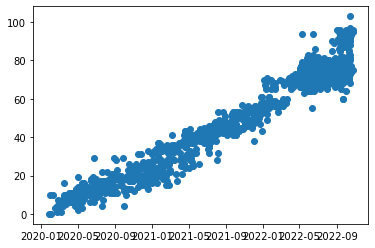

In [16]:
#change date to python format and plot
dates = [pd.to_datetime(d) for d in date_dict.values()]
divergence = [d for d in divergence_dict.values()]
taxa = [d for d in divergence_dict.keys()]
plt.scatter(dates,divergence)

### Change YYYY-MM-DD to python float 

In [17]:
def datetime_to_float(d):
    return d.timestamp()
dates = [(datetime_to_float(d)-datetime_to_float(dates[0]))*2.850029e-8 for d in dates]
dates[:10]

[0.0,
 0.275791606272,
 0.115733977632,
 0.120658827744,
 0.068947901568,
 0.167444903808,
 0.10342185235200001,
 0.108346702464,
 0.327502532448,
 0.177294604032]

coefficient of determination: 0.9488161046135505
intercept: [-0.52950389]
slope: [[33.50000002]]


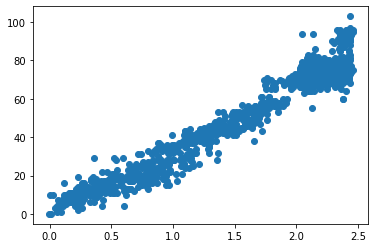

In [18]:
#Rerun linear analysis from Nextstrain
x = np.array(dates).reshape((-1, 1))
y = np.array(divergence)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
plt.scatter(x,y)

new_model = LinearRegression().fit(x, y.reshape((-1, 1)))
print(f"intercept: {new_model.intercept_}")


print(f"slope: {new_model.coef_}")

In [19]:
print(x[:5],y[:5])
x = np.array(dates)

[[0.        ]
 [0.27579161]
 [0.11573398]
 [0.12065883]
 [0.0689479 ]] [10. 16.  6.  7.  7.]


## 3 Analysis

### Scan increasing number of breakpoints and score

In [21]:
ms = piecewise_regression.ModelSelection(x, y, max_breakpoints=6, n_boot = 2000)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     8615.0         True   5.9462e+04 
1                     8373.8         True   5.4283e+04 
2                     8058.7         True   4.8274e+04 
3                     7937.0         True   4.5974e+04 
4                     7904.9         True     4.52e+04 
5                     7917.0         True   4.5139e+04 
6                                   False              

Min BIC (Bayesian Information Criterion) suggests best model


### Plot BIC scores 

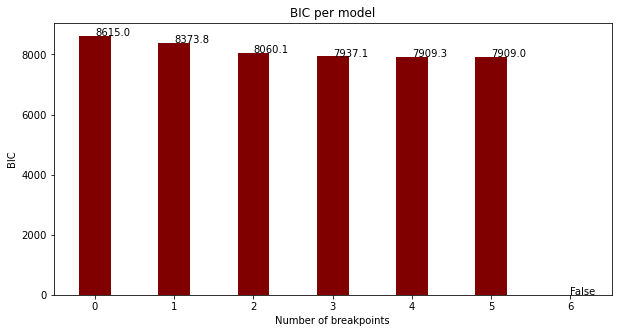

In [22]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

# creating the dataset
data = {'0':8615.0, '1':8373.8, '2':8060.1,
		'3':7937.1,'4':7909.3,'5':7909.0,'6':False}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
		width = 0.4)

plt.xlabel("Number of breakpoints")
addlabels(courses,values)
plt.ylabel("BIC")
plt.title("BIC per model")
plt.show()


### Plot min bic model

In [40]:
#Fit biologically simple model
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=5,n_boot=200)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                     2821
No. Model Parameters                   12
Degrees of Freedom                   2809
Res. Sum of Squares               45076.5
Total Sum of Squares          1.16172e+06
R Squared                        0.961199
Adjusted R Squared               0.961033
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                4.58876        0.517       8.8788      1.18e-18       3.5754       5.6021
alpha1               21.8035         1.17       18.664      2.23e-73       19.513       24.094
beta1                16.6984          1.9       8.8045             -        12.98       20.417
beta2               -14.5636         9.94      -1.4651             -      -34.055       4.9278
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                     2821\nNo. Model Parameters                   12\nDegrees of Freedom                   2809\nRes. Sum of Squares               45076.5\nTotal Sum of Squares          1.16172e+06\nR Squared                        0.961199\nAdjusted R Squared               0.961033\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                4.58876        0.517       8.8788      1.18e-18       3.5

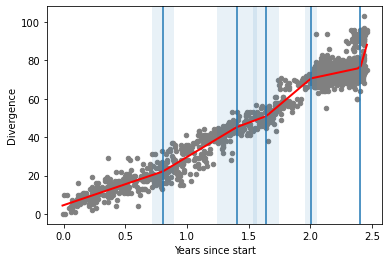

In [41]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=2)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("Years since start")
plt.ylabel("Divergence")
plt.show()
plt.close()

### Plot biologically simple model

In [39]:
#Fit biologically simple model
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=2,n_boot=25)
print(pw_fit.summary()[0])


                    Breakpoint Regression Results                     
No. Observations                     2821
No. Model Parameters                    6
Degrees of Freedom                   2815
Res. Sum of Squares               48319.2
Total Sum of Squares          1.16172e+06
R Squared                        0.958407
Adjusted R Squared               0.958319
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                4.67675        0.509       9.1876      7.58e-20       3.6786       5.6749
alpha1                21.474         1.05        20.38      3.12e-86       19.408        23.54
beta1                18.2529         1.12       16.226             -       16.047       20.459
beta2                -20.673        0.973       -21.25             -      -22.581      -18.765
breakpoint1      

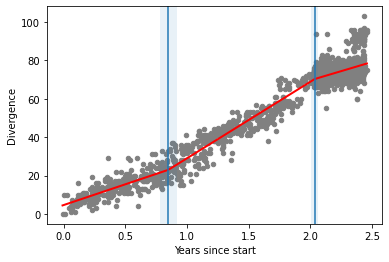

In [26]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=2)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("Years since start")
plt.ylabel("Divergence")
plt.show()
plt.close()

## 5 Color plot (in the works)

In [42]:
#open nexus tree to color plot
tree_nex = dendropy.Tree.get(
    path="nextstrain_ncov_open_global_6m_tree.nexus",
    schema="nexus",
    )
print(tree.as_string(schema="newick",)[:30])

(('Wuhan-Hu-1/2019':0.0,(('GBR


In [43]:
#with open('nextstrain_ncov_gisaid_global_6m_tree.nexus') as f:
with open('nextstrain_ncov_open_global_6m_tree.nexus') as f:
    lines = f.readlines()        

    # Change directory
    # os.chdir("Your file path")

    # Import the customers data as data frames
    # filename = "customers lists input.xlsx"
    # customers = pd.read_excel(filename)

    # Clean customers lists
    B_cleaned = metadata['strain']
    A_cleaned = lines[2].split(':')
    print(len(A_cleaned))
    print(len(B_cleaned))

    # Perform fuzzy string matching
    tuples_list = [max([(fuzz.token_set_ratio(i,j),j) for j in B_cleaned]) for i in A_cleaned]

    # Unpack list of tuples into two lists
    similarity_score, fuzzy_match = map(list,zip(*tuples_list))

    # Create pandas DataFrame
    df = pd.DataFrame({"list_A":A_cleaned, "fuzzy match": fuzzy_match, "similarity score":similarity_score})
    print(df)

4831
6308187


NameError: name 'fuzz' is not defined

In [44]:
print(len(A_cleaned))
print(len(B_cleaned))

print(A_cleaned[:5])
print(B_cleaned[:5])
print(tree.taxon_namespace[:5])
print(tree_nex.taxon_namespace[:5])

4831
6308187
['  tree one = ((Wuhan-Hu-1/2019[&clade_membership=19A,num_date=2019.9849315068493,num_date_CI={2019.9849315068493,2019.9849315068493},emerging_lineage=19A,pango_lineage=B,Nextclade_pango=B,region=Asia,country=China,division=China,host=Homo sapiens,recency=Older,epiweek=201952]', '0,(AUS/SA04/2020[&clade_membership=19A,num_date=2020.0806010928961,num_date_CI={2020.0806010928961,2020.0806010928961},emerging_lineage=19A,pango_lineage=B.1,Nextclade_pango=B,mutational_fitness=0.000360522,region=Oceania,country=Australia,division=South Australia,host=Homo sapiens,recency=Older,epiweek=202005]', '4,((IND/nimh-7139/2020[&clade_membership=19A,num_date=2020.3237704918033,num_date_CI={2020.3237704918033,2020.3237704918033},emerging_lineage=19A,pango_lineage=B.6,Nextclade_pango=B.6.6,mutational_fitness=-0.07957380600000001,region=Asia,country=India,division=India,host=Homo sapiens,recency=Older,epiweek=202018]', '5,(NZL/20VR0174/2020[&clade_membership=19A,num_date=2020.1571038251366,

In [50]:
with open('nextstrain_ncov_open_global_6m_tree.nexus') as f:
    lines = f.readlines()        
    print(lines[-2].strip()[:30])
    for nex_taxa in tree_nex.taxon_namespace:
        #print(nex_taxa.label)
        pos = lines[-2].find(nex_taxa.label)
        #print('pos',lines[-2].find(nex_taxa.label))
        #try:
        #    print()
            #print('date',metadata['date'][nex_taxa.label.replace(' ','_')])
            
            
        #except:
        #    print()
            #print('WAIT')
            #print()
            
    

tree one = ((Wuhan-Hu-1/2019[&
